### Friends Recommender In Social Network

#### Эмбеддинги и Кластеризация 

https://github.com/iamsinghrajat/Friends-Recommender-In-Social-Networkz

Dataset: https://snap.stanford.edu/data/ego-Facebook.html 
Датасет содержит 10 графов. 
Каждый граф имеет свои вершины, ребра, фичи.

In [2]:
# !pip install torchnet networkx
%matplotlib inline

import json
import collections
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ReLU, Linear, Dropout

from torch_geometric.data import Data
# from torch_geometric.transforms import AddTrainValTestMask as masking
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv, Sequential
from torch_geometric.nn.norm import BatchNorm

import os
from os.path import exists

import networkx as nx

## Формируем граф

In [3]:
DATASET_PATH = "datasets/SNAP_ego-Facebook/"
dataset_file = "facebook_combined.txt" 
FEATURES_PATH =  "datasets/SNAP_ego-Facebook/facebook/"

In [4]:
nets = [0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980]
graph_nets = {}
nodes_nets = {k:set([]) for k in nets}

In [5]:
def add_edge(g, node1, node2):
    if node1 in g:
        g[node1].add(node2)
    else:
        g[node1] = set([node2])
    
# Первичное заполенние ребер графа из файла facebook_combined.txt, далее будет еще дозаполнятся из доп данных, 
# там почему-то связи разнятся с тем что тут указано. Возможно это сделано в качестве деления трайн/тест 
def beginer_load_graph(filename=DATASET_PATH + dataset_file):
    graph = {}
    with open(filename, "r") as file:
        for row in file:
            row = row.strip().split()
            if len(row) < 2:
                continue
            node1_id, node2_id = list(map(int, row))
            add_edge(graph, node1_id, node2_id)
            add_edge(graph, node2_id, node1_id)
    return graph
begin_graph = beginer_load_graph()

In [6]:
# def load_features(nets):
#     nodes_features = {}
#     # загружаем фичи основных узлов по сетям
#     for net_num in nets:
#         ego_filename = FEATURES_PATH + f"{net_num}.egofeat"
#         with open(ego_filename, "r") as file:
#             node_feat = file.readline().strip().split()
#             nodes_features[net_num] = list(map(int, node_feat))
#         # загружаем все остальные фичи по узлам
#         nodes_features
#         feats_filename = FEATURES_PATH + f"{net_num}.feat"
#         with open(feats_filename, "r") as file:
#             for row in file:
#                 node_feat = row.strip().split()
#                 node_feat = list(map(int, node_feat))
#                 nodes_features[node_feat[0]] = node_feat[1:]
#     return nodes_features

    
# nodes_features = load_features(nets=nets)
# assert len(nodes_features) == len(begin_graph.keys()), "Не для всех узлов есть фичи"

def load_features(net_num):
    nodes_features = {}
    # загружаем фичи основных узлов по сетям
    ego_filename = FEATURES_PATH + f"{net_num}.egofeat"
    with open(ego_filename, "r") as file:
        node_feat = file.readline().strip().split()
        nodes_features[net_num] = list(map(int, node_feat))
    # загружаем все остальные фичи по узлам
    nodes_features
    feats_filename = FEATURES_PATH + f"{net_num}.feat"
    with open(feats_filename, "r") as file:
        for row in file:
            node_feat = row.strip().split()
            node_feat = list(map(int, node_feat))
            nodes_features[node_feat[0]] = node_feat[1:]
    return nodes_features

In [7]:
def extend_load_graph(graph, net_num):
    nodes = set([net_num]) # номер подграфа это также вершина, которую надо учитывать
    edges_filename = FEATURES_PATH + f"{net_num}.edges"
    with open(edges_filename, "r") as edges_file:
        for row in edges_file:
            row = row.strip().split()
            if len(row) < 2:
                continue
            node1_id, node2_id = list(map(int, row))
            add_edge(graph, node1_id, node2_id)
            add_edge(graph, node2_id, node1_id)
            nodes.add(node1_id)
            nodes.add(node2_id)
    return graph, nodes

In [8]:
graphes = {}
# Формируем подграфы
for net_num in nets:
    print(f"net_num:{net_num}")
    nodes_features_net = load_features(net_num=net_num)
    nodes_net = nodes_features_net.keys()
#     print(nodes_net)
#     print(f"feat siez: {len(nodes_features_net[nodes_net[0]])}")
    
    # пока не используем расчет local_graph, используем только те ребра которые указаны для каждого графа в файлу edge
    local_graph = {k: begin_graph[k] for k in nodes_net}
    graph_net, nodes_net = extend_load_graph(graph={}, net_num=net_num)
    
    graph_nets[net_num] = graph_net
    nodes_nets[net_num] = list(graph_nets[net_num].keys())
    edges_net = [[nodes_nets[net_num].index(v1), nodes_nets[net_num].index(v2)] for v1 in graph_nets[net_num] for v2 in graph_nets[net_num][v1]]
    edges_net = torch.tensor(edges_net)
    x = torch.tensor([nodes_features_net[v] for v in nodes_nets[net_num]], dtype=torch.float)
    
    graph_data = Data(x=x, edge_index=edges_net.t().contiguous())
    
    print(graph_data)
    graph_data.validate(raise_on_error=True)
    graphes[net_num] = graph_data  


net_num:0
Data(x=[333, 224], edge_index=[2, 5038])
net_num:107
Data(x=[1034, 576], edge_index=[2, 53498])
net_num:348
Data(x=[224, 161], edge_index=[2, 6384])
net_num:414
Data(x=[150, 105], edge_index=[2, 3386])
net_num:686
Data(x=[168, 63], edge_index=[2, 3312])
net_num:698
Data(x=[61, 48], edge_index=[2, 540])
net_num:1684
Data(x=[786, 319], edge_index=[2, 28048])
net_num:1912
Data(x=[747, 480], edge_index=[2, 60050])
net_num:3437
Data(x=[534, 262], edge_index=[2, 9626])
net_num:3980
Data(x=[52, 42], edge_index=[2, 292])


### Эмбеддинги и Кластеризация 

In [9]:
select_net = 107
num_features = len(graphes[select_net].x[0])
num_features

576

In [10]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(576, 16)
  (conv2): GCNConv(16, 2)
)


In [11]:
data = graphes[select_net]
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)

In [12]:
out[:2], torch.argmax(out[:50], dim=1)

(tensor([[ 0.0260, -0.0568],
         [ 0.0285, -0.0423]], grad_fn=<SliceBackward0>),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
         0, 0]))

In [13]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


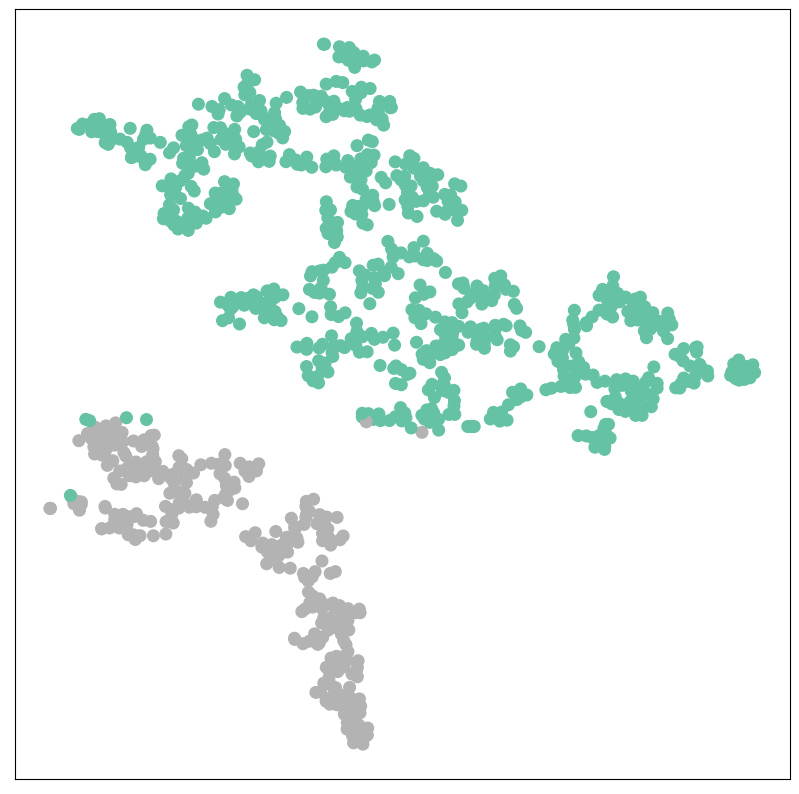

In [14]:
visualize(out, color=torch.argmax(out, dim=1))

In [90]:
select_net = 107
num_features = len(graphes[select_net].x[0])

In [91]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.gcn_layers = Sequential('x, edge_index',[
            (GCNConv(num_features, hidden_channels), 'x, edge_index -> x'),
            ReLU(),
            Dropout(p=0.5),
            BatchNorm(hidden_channels),
            (GCNConv(hidden_channels, hidden_channels*2), 'x, edge_index -> x'),
            ReLU(),
            Dropout(p=0.5),
            (GCNConv(hidden_channels*2, 2), 'x, edge_index -> x'),
#             Linear(hidden_channels*2, 2),
        ]
        )
        
        self.conv1 = GCNConv(num_features, hidden_channels)

    def forward(self, x, edge_index):
        x = self.gcn_layers(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (gcn_layers): Sequential(
    (0): GCNConv(576, 16)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): BatchNorm(16)
    (4): GCNConv(16, 32)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): GCNConv(32, 2)
  )
  (conv1): GCNConv(576, 16)
)


In [92]:
data = graphes[select_net]
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)

D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


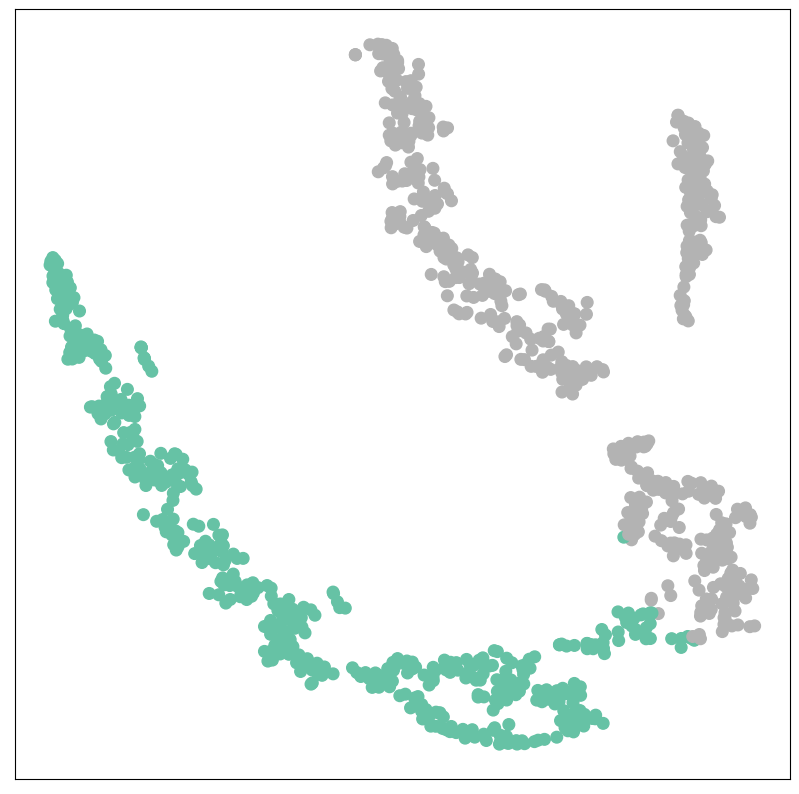

In [93]:
visualize(out, color=torch.argmax(out, dim=1))

#### DBSCAN кластеризация

In [148]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=0.005, min_samples=5)

In [149]:
dbs.fit(out.detach().cpu())

DBSCAN(eps=0.005)

In [150]:
labels = dbs.labels_
labels.min(), labels.max()
labels

array([ 0,  0,  0, ...,  1, -1,  1], dtype=int64)

In [151]:
z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
df_dbscan = pd.DataFrame(z)
df_dbscan["label"] = labels
# df_dbscan

D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


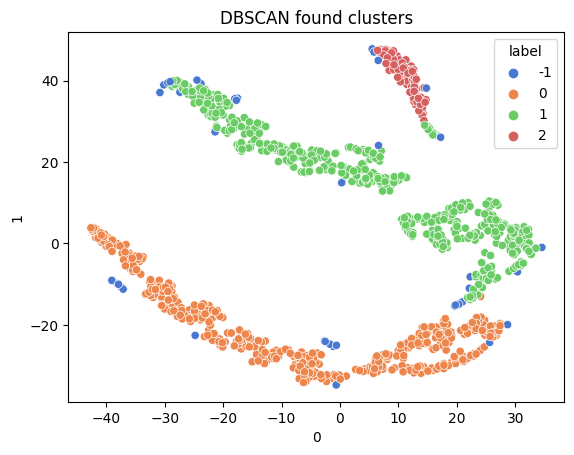

In [152]:
import seaborn as sns
sns.scatterplot(data=df_dbscan, x=0, y=1, 
                hue='label', palette='muted').set_title('DBSCAN found clusters');

### Поиск похожих вершин

### KNN

In [53]:
select_net = 0
num_features = len(graphes[select_net].x[0])

In [78]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.gcn_layers = Sequential('x, edge_index',[
            (GCNConv(num_features, hidden_channels), 'x, edge_index -> x'),
            ReLU(),
            Dropout(p=0.5),
            BatchNorm(hidden_channels),
            (GCNConv(hidden_channels, hidden_channels*2), 'x, edge_index -> x'),
#             ReLU(),
#             Dropout(p=0.5),
#             (GCNConv(hidden_channels*2, 30), 'x, edge_index -> x'),
        ]
        )
        
        self.conv1 = GCNConv(num_features, hidden_channels)

    def forward(self, x, edge_index):
        x = self.gcn_layers(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (gcn_layers): Sequential(
    (0): GCNConv(224, 16)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): BatchNorm(16)
    (4): GCNConv(16, 32)
  )
  (conv1): GCNConv(224, 16)
)


In [79]:
data = graphes[select_net]
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)

In [80]:
select_node = 187
nodes_nets[select_net][select_node]

196

In [81]:
out = out.detach().cpu()
out.shape

torch.Size([333, 32])

In [82]:
list(nodes_nets[select_net]).index(196)

187

In [83]:
out[select_node], out[select_node][None]

(tensor([ 0.0108,  0.0780, -0.0366, -0.0494, -0.0070, -0.0166,  0.0408, -0.1074,
          0.0703,  0.0155, -0.0200, -0.0476,  0.0214, -0.0100,  0.0205,  0.0670,
          0.0947, -0.0478, -0.0707, -0.0150, -0.0206,  0.1139,  0.0286,  0.0044,
          0.0439,  0.0488, -0.0357, -0.0210,  0.0439, -0.0732,  0.0538,  0.0186]),
 tensor([[ 0.0108,  0.0780, -0.0366, -0.0494, -0.0070, -0.0166,  0.0408, -0.1074,
           0.0703,  0.0155, -0.0200, -0.0476,  0.0214, -0.0100,  0.0205,  0.0670,
           0.0947, -0.0478, -0.0707, -0.0150, -0.0206,  0.1139,  0.0286,  0.0044,
           0.0439,  0.0488, -0.0357, -0.0210,  0.0439, -0.0732,  0.0538,  0.0186]]))

In [84]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5)
knn.fit(out)
knn

NearestNeighbors()

In [87]:
neighbors = knn.kneighbors(out[select_node][None], n_neighbors =10 , return_distance = False)
print(neighbors)

[[187 173   4  36 134  47 100 166  37 221]]


In [88]:
print(f"node by index: {nodes_nets[select_net][select_node]}")
print(f"find neighbors: {[nodes_nets[select_net][i] for i in neighbors[0]]}")

node by index: 196
find neighbors: [196, 330, 24, 254, 187, 299, 302, 266, 194, 101]


In [77]:
print(f"node by index: {nodes_nets[select_net][select_node]}")
print(f"find neighbors: {[nodes_nets[select_net][i] for i in neighbors[0]]}")

node by index: 196
find neighbors: [196, 330, 57, 24, 187]


https://medium.com/mlearning-ai/embedding-similarity-search-25c6911240af

In [ ]:
from annoy import AnnoyIndex
import random
t = AnnoyIndex(d, 'angular')  # Length of item vector that will be indexed
for i in range(len(S)):
    t.add_item(i, S[i])
    
t.build(10) # 10 trees
print(u.get_nns_by_vector(x, k)) # will find the k nearest neighbours

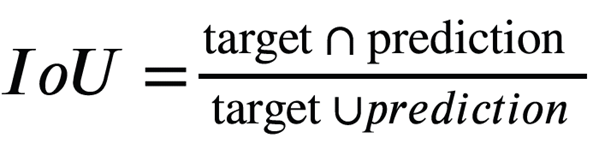

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 